# ONNX visualization

[ONNX](https://onnx.ai/) is a serialization format for machine learned model. It is a list of mathematical functions used to describe every prediction function for standard and deep machine learning. Module [onnx](https://github.com/onnx/onnx) offers some tools to [display ONNX graph](http://www.xavierdupre.fr/app/sklearn-onnx/helpsphinx/auto_examples/plot_pipeline.html). [Netron](https://github.com/lutzroeder/netron) is another approach. The following notebooks explore a ligher visualization.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Train a model

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Convert a model

In [3]:
import numpy
from skl2onnx import to_onnx
model_onnx = to_onnx(clr, X_train.astype(numpy.float32))

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


## Explore it with OnnxInference

In [4]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(model_onnx)
sess

OnnxInference(...)

In [5]:
print(sess)

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.9999"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "X"
    output: "label"
    output: "probability_tensor"
    name: "LinearClassifier"
    op_type: "LinearClassifier"
    attribute {
      name: "classlabels_ints"
      ints: 0
      ints: 1
      ints: 2
      type: INTS
    }
    attribute {
      name: "coefficients"
      floats: 0.4181073009967804
      floats: 1.3475124835968018
      floats: -2.106691598892212
      floats: -0.9460089802742004
      floats: 0.26472803950309753
      floats: -1.3079595565795898
      floats: 0.5594020485877991
      floats: -1.1842355728149414
      floats: -1.5042835474014282
      floats: -1.3339447975158691
      floats: 2.113557815551758
      floats: 2.331017017364502
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 0.2748755216598511
      floats: 0.6917440295219421
      floats: -0.9082133769989014
      type: FL

## dot

In [6]:
dot = sess.to_dot()
print(dot)

digraph{
  nodesep=0.05;
  orientation=portrait;
  ranksep=0.25;

  X [shape=box color=red label="X\nfloat((1, 4))" fontsize=10];

  output_label [shape=box color=green label="output_label\nint64((1,))" fontsize=10];
  output_probability [shape=box color=green label="output_probability\n[{int64, {'kind': 'tensor', 'elem': 'float', 'shape': }}]" fontsize=10];


  label [shape=box label="label" fontsize=10];
  probability_tensor [shape=box label="probability_tensor" fontsize=10];
  LinearClassifier [shape=box style="filled,rounded" color=orange label="LinearClassifier\n(LinearClassifier)\nclasslabels_ints=[0 1 2]\ncoefficients=[ 0.4181073   1.34...\nintercepts=[ 0.27487552  0.6917...\nmulti_class=1\npost_transform=b'LOGISTIC'" fontsize=10];
  X -> LinearClassifier;
  LinearClassifier -> label;
  LinearClassifier -> probability_tensor;

  probabilities [shape=box label="probabilities" fontsize=10];
  Normalizer [shape=box style="filled,rounded" color=orange label="Normalizer\n(Normalizer)

In [7]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

## magic commands

The module implements a magic command to easily display graphs.

In [8]:
%load_ext mlprodict

In [9]:
%onnxview model_onnx

## runtime

Let's compute the prediction using a Python runtime.

In [10]:
prob = sess.run({'X': X_test})['output_probability']
prob[:5]

[{0: 0.0006534390445303331, 1: 0.30093526761343764, 2: 0.6984112933420319},
 {0: 0.05447472660142438, 1: 0.7737428507476106, 2: 0.17178242265096508},
 {0: 0.060407965085748104, 1: 0.4108043263294768, 2: 0.5287877085847751},
 {0: 0.03491727124773897, 1: 0.5799452962133731, 2: 0.38513743253888794},
 {0: 0.1540491422601718, 1: 0.6669965330634808, 2: 0.17895432467634728}]

In [11]:
import pandas
prob = pandas.DataFrame(prob).values
prob[:5]

array([[6.53439045e-04, 3.00935268e-01, 6.98411293e-01],
       [5.44747266e-02, 7.73742851e-01, 1.71782423e-01],
       [6.04079651e-02, 4.10804326e-01, 5.28787709e-01],
       [3.49172712e-02, 5.79945296e-01, 3.85137433e-01],
       [1.54049142e-01, 6.66996533e-01, 1.78954325e-01]])

Which we compare to the original model.

In [12]:
clr.predict_proba(X_test)[:5]

array([[6.53439000e-04, 3.00935296e-01, 6.98411265e-01],
       [5.44747200e-02, 7.73742863e-01, 1.71782417e-01],
       [6.04079599e-02, 4.10804357e-01, 5.28787683e-01],
       [3.49172684e-02, 5.79945313e-01, 3.85137419e-01],
       [1.54049131e-01, 6.66996547e-01, 1.78954322e-01]])

Some time measurement...

In [13]:
%timeit clr.predict_proba(X_test)

115 µs ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit sess.run({'X': X_test})['output_probability']

295 µs ± 48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


With one observation:

In [15]:
%timeit clr.predict_proba(X_test[:1])

123 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit sess.run({'X': X_test[:1]})['output_probability']

89.3 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%matplotlib inline

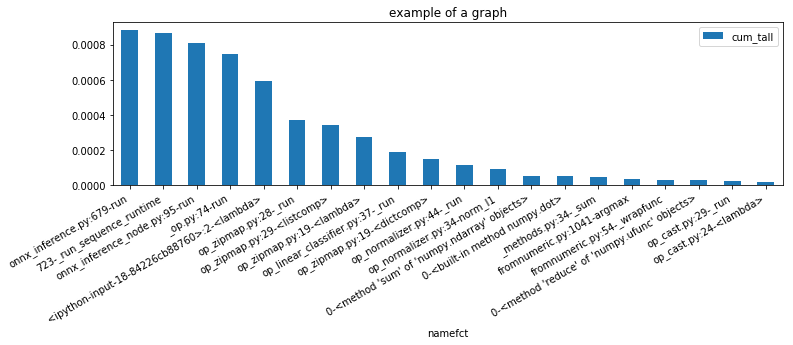

In [18]:
from pyquickhelper.pycode.profiling import profile
pr, df = profile(lambda: sess.run({'X': X_test})['output_probability'], as_df=True)
ax = df[['namefct', 'cum_tall']].head(n=20).set_index('namefct').plot(kind='bar', figsize=(12, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');